# Implementando classe para fazer o Delay and Sum paralelizado

A classe deverá receber uma matriz em que cada linha é um sinal de algum microfone. O primeiro sinal sempre será o referencial. 

A classe deverá ajustar os delays de acordo com uma análise de auto-correlação no domínio do tempo.

In [25]:
from joblib import Parallel, delayed
from IPython.display import Audio
from random import randint, random
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("/home/dimi/Programming/IC2019/DOA/Python/")
from SimularArrayMicrofonesClass import SimularArrayMicrofones
from GeneralizedSidelobeCancellerClass import GeneralizedSidelobeCanceller

### Importando um áudio para usar como teste

A parte de importar os áudios de um array de microfones não deverá fazer parte da classe. A classe só vai receber arrays numpy.

Qtd amostras cada mic: 286584
Delays verdadeiros: [0, -5, -5, 0]

Sinais verdadeiros:


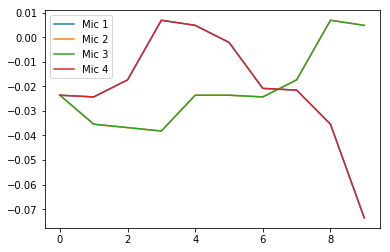


Delays corrigidos:


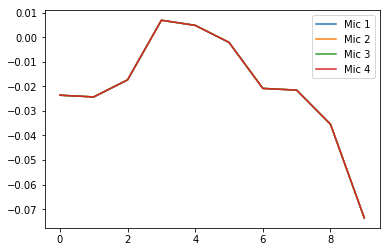

In [2]:
coordenadasMics = np.array([[0,0,0],[0,0.04137,0.04137],[0.0585,0.04137,0.04137],[0.0585,0,0]])
objSimularArrayMics = SimularArrayMicrofones("/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono6Segundos.wav", energiaRuido=None, normalizarEnergia=True, azimutalRad=None, elevacaoRad=None, coordenadasMics=coordenadasMics)
arraySinaisMics, delaysVerdadeiros, freqAmostragem = objSimularArrayMics.obterResultado()

print("Qtd amostras cada mic:", len(arraySinaisMics[0]))
print("Delays verdadeiros:", delaysVerdadeiros)

print("\nSinais verdadeiros:")
inicio = 100000
fim    = inicio + 10
for i, sinalAtual in enumerate(arraySinaisMics):
    plt.plot(sinalAtual[inicio:fim], label="Mic "+str(i+1))
plt.legend()
plt.show()

print("\nDelays corrigidos:")
for i, sinalAtual in enumerate(arraySinaisMics):
    plt.plot(sinalAtual[inicio-delaysVerdadeiros[i]:fim-delaysVerdadeiros[i]], label="Mic "+str(i+1))
plt.legend()
plt.show()

## Iniciando a implementação

### Função para passar de tempo para amostras

In [3]:
def tempoParaAmostras(tempoEmSegundos, freqAmostragem):
    return freqAmostragem * tempoEmSegundos

In [4]:
tempoParaAmostras(1.4, freqAmostragem)

61739.99999999999

### Função para calcular a maior distância entre um microfone e o microfone referencial 

Essa função será essencial para a realização do cálculo do delay máximo possível.

In [5]:
def calcularMaiorDistanciaMics(coordenadasMics):
    arrayDistancias = Parallel(n_jobs=-1)(delayed(np.linalg.norm)(coordenadaAtual-coordenadasMics[0]) for coordenadaAtual in coordenadasMics[1:])
    return np.amax(arrayDistancias)    

In [6]:
maiorDistancia = calcularMaiorDistanciaMics(coordenadasMics)
print(maiorDistancia)

0.08273574680874042


### Função para calcular o delay máximo

O delay máximo será o tempo necessário para o som percorrer o caminho entre o microfone de referência e o microfone mais distante. Basta converter esse tempo para amostras, posteriormente.

In [7]:
def calcularDelayMaximo(coordenadasMics, freqAmostragem, velocidadeSom=340.29):
    # CALCULO A MAIOR DISTANCIA ENTRE UM MIC E O MIC REFERENCIAL
    maiorDistancia = calcularMaiorDistanciaMics(coordenadasMics)
    # CALCULO O TEMPO NECESSARIO PRO SOM PERCORRER A MAIOR DISTANCIA ENTRE UM MIC E O MIC DE REF
    tempoEmSegundos = maiorDistancia/velocidadeSom
    # PASSO PRA AMOSTRAS
    amostras = tempoParaAmostras(tempoEmSegundos, freqAmostragem)
    # ARREDONDO PRA CIMA
    return int(np.ceil(amostras))

In [8]:
delayMax = calcularDelayMaximo(coordenadasMics, freqAmostragem)
delayMax

11

### Função para calcular a correlação entre dois arrays

In [9]:
def calcularCorrelacao(a, b):
    return np.corrcoef(a, b)[0][1]

### Função para ajustar dois sinais dado um delay a ser testado

Supondo que eu determine que um delay entre dois sinais é -4. Quero reconstruir os sinais para testar a correlação entre eles com esse delay.

In [10]:
def ajustarSinaisDadoDelay(a, b, delayDesejado, delayMax):
    inicioB = delayMax - delayDesejado
    fimB    = -delayMax - delayDesejado
    if fimB == 0:
        fimB = None
    return a[delayMax:-delayMax], b[inicioB:fimB]

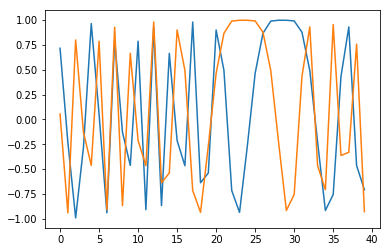

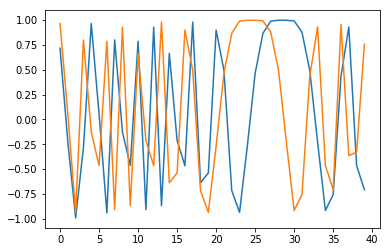

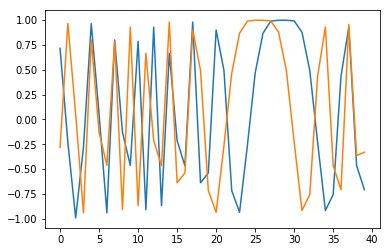

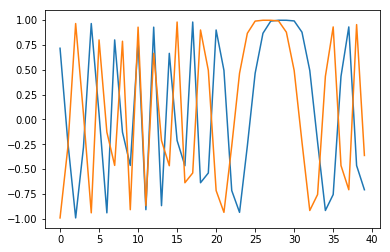

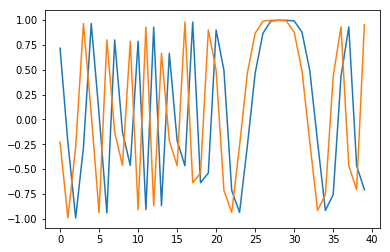

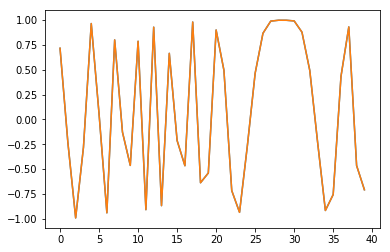

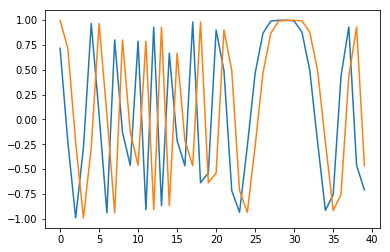

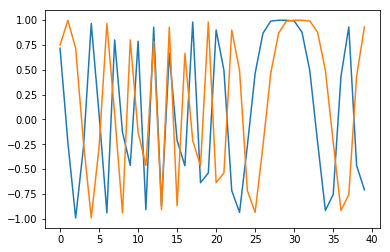

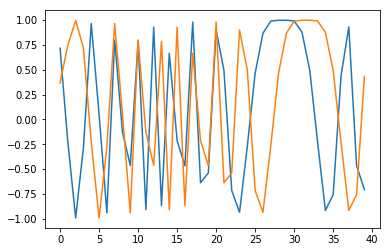

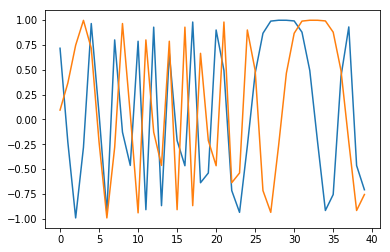

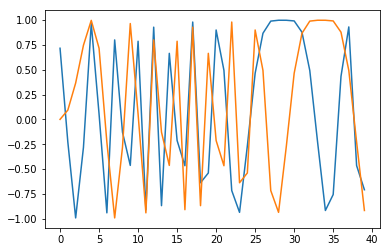

In [11]:
delayMax = 5
x = np.linspace(0, 3*delayMax)
a = np.sin(x*x)
b = np.sin(x*x)

for i in range(-delayMax, delayMax+1):
    aNovo, bNovo = ajustarSinaisDadoDelay(a, b, i, delayMax)
    plt.plot(aNovo)
    plt.plot(bNovo)
    plt.show()

### Função para plotar a correlação em função do delay

Essa função só vai servir para testes mesmo. Não será usada de verdade.

In [12]:
def correlacaoXDelay(sinalA, sinalB, delayMax):
    
    arrayCorrelacoes = []
    
    for delayAtual in range(-delayMax, delayMax + 1):
        sinalAAjustado, sinalBAjustado = ajustarSinaisDadoDelay(sinalA, sinalB, delayAtual, delayMax)        
        correlacaoAtual = calcularCorrelacao(sinalAAjustado, sinalBAjustado)
        arrayCorrelacoes.append(correlacaoAtual)
        
    return arrayCorrelacoes

### Função para calcular a defasagem entre dois sinais quaisquer

Como foi observado que o gráfico Correlação x Delay é sempre quadrático com concavidade para baixo, essa função tenta calcular o menor número de correlações quanto possível.

Em primeiro lugar, ela calcula as correlações para os delays -1, 0 e 1. Com isso, ela vai saber em qual direção seguir. Isto é, os delays aumentam pra direita ou para a esquerda do gráfico? Sabendo isso, ela segue na direção em que as correlações aumentam e só para quando uma das correlações for mais baixa que a iteração anterior, pois, dessa forma, sabe-se que o pico foi encontrado.

In [13]:
def calcularDefasagemEntreDoisSinais(sinalA, sinalB, delayMax):
    
    # COMECO CALCULANDO COM OS DELAYS -1, 0 E 1. DEPOIS EU VEJO PRA QUAL DIRECAO EU VOU
    sinalAAjustado, sinalBAjustado = ajustarSinaisDadoDelay(sinalA, sinalB, -1, delayMax)
    correlacaoMenosUm = calcularCorrelacao(sinalAAjustado, sinalBAjustado)
    sinalAAjustado, sinalBAjustado = ajustarSinaisDadoDelay(sinalA, sinalB, 0, delayMax)
    correlacaoZero    = calcularCorrelacao(sinalAAjustado, sinalBAjustado)
    sinalAAjustado, sinalBAjustado = ajustarSinaisDadoDelay(sinalA, sinalB, 1, delayMax)
    correlacaoMaisUm  = calcularCorrelacao(sinalAAjustado, sinalBAjustado)
    
    # VERIFICANDO PRA QUAL DIRECAO EU VOU
    if correlacaoZero > correlacaoMenosUm and correlacaoZero > correlacaoMaisUm:
        # SE ENTROU AQUI E PQ DELAY 0 DA A MAIOR CORRELACAO
        return 0
    elif correlacaoMaisUm > correlacaoZero and correlacaoMaisUm > correlacaoMenosUm:
        # SE ENTROU AQUI A GNT VAI PRA CIMA
        maiorCorrelacao      = correlacaoMaisUm
        delayMaiorCorrelacao = 1
        rangeDelays          = np.arange(2, delayMax + 1, 1)
    elif correlacaoMenosUm > correlacaoZero and correlacaoMenosUm > correlacaoMaisUm:
        # SE ENTROU AQUI A GNT VAI PRA BAIXO
        maiorCorrelacao      = correlacaoMenosUm
        delayMaiorCorrelacao = -1
        rangeDelays          = np.arange(-2, -delayMax - 1, -1)
    else:
        # NAO E POSSIVEL QUE ENTRE AQUI MEU DEUS, MAS SO PRA GARANTIR NE...
        return None
    
    # SE A FUNCAO CHEGAR ATE AQUI E PQ AINDA NAO HOUVE RETORNO. VAMOS CONTINUAR TESTANDO OS DELAYS
    for delayAtual in rangeDelays:
        
        # CALCULO A CORRELACAO COM O DELAY ATUAL
        sinalAAjustado, sinalBAjustado = ajustarSinaisDadoDelay(sinalA, sinalB, delayAtual, delayMax)
        correlacaoAtual = calcularCorrelacao(sinalAAjustado, sinalBAjustado)
        
        # JA QUE ESTAMOS INDO NA DIRECAO EM QUE A CORRELACAO AUMENTA, 
        # SE ELA DIMINUIR E PQ A GNT TINHA CHEGADO NO PICO NA ITERACAO ANTERIOR
        if correlacaoAtual < maiorCorrelacao:
            break
            
        # SE NAO DIMINUIU ENTAO SEGUE O BAILE
        maiorCorrelacao      = correlacaoAtual
        delayMaiorCorrelacao = delayAtual
        
    return delayMaiorCorrelacao

Delay encontrado: -5


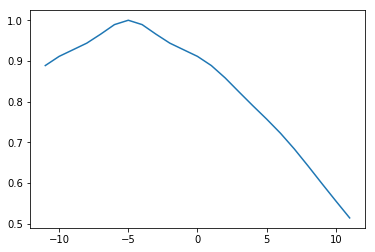

In [14]:
delayMax = 11

# CONSTRUINDO OS SINAIS
sinalA = arraySinaisMics[0]
sinalB = arraySinaisMics[1]

# OBSERVANDO AS CORRELACOES
arrayCorrelacoes = correlacaoXDelay(sinalA, sinalB, delayMax)
plt.plot(range(-delayMax, delayMax + 1), arrayCorrelacoes)

# TESTANDO A FUNCAO MAIS RAPIDA
delayEncontrado = calcularDefasagemEntreDoisSinais(sinalA, sinalB, delayMax)
print("Delay encontrado:", delayEncontrado)

### Função para calcular o array de delays

Essa função vai usar a função anterior para calcular o delay entre cada microfofe e o microfone de origem. Ela deverá ser paralelizada, assim, cada núcleo fica responsável por uma combinação.

In [15]:
def calcularArrayDelays(arraySinaisMics, delayMax):
    
    # PARA CADA MIC QUE NAO SEJA O REFERENCIAL
    arrayDelays = Parallel(n_jobs=-1)(delayed(calcularDefasagemEntreDoisSinais)(arraySinaisMics[0], sinalAtual, delayMax) for sinalAtual in arraySinaisMics[1:])
    
    # TEM QUE TER O 0 NO COMECO PQ EH O DELAY ENTRE O REFERENCIAL E ELE MESMO
    return np.array([0] + arrayDelays)

In [16]:
# FAZENDO ALGUMAS REPETICOES
for i in range(0, 10):
    
    # SIMULANDO UM ARRAY DE MICROFONES
    objSimularArrayMics = SimularArrayMicrofones("/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono6Segundos.wav", energiaRuido=None, normalizarEnergia=True)
    arraySinaisMics, delaysVerdadeiros, freqAmostragem = objSimularArrayMics.obterResultado()
    
    # CALCULANDO OS DELAYS
    arrayDelays = calcularArrayDelays(arraySinaisMics, delayMax)
    
    # SE ERRAR ALGUM EU MOSTRO
    if not np.array_equal(arrayDelays, delaysVerdadeiros):
        print("\nERRO!")
        print("Delays verdadeiros:", delaysVerdadeiros)
        print("Delays calculados:", arrayDelays, "\n")

### Função para executar o Delay and Sum dado os array de delays e de sinais

In [17]:
def executarDaS(arraySinaisOriginais, arrayDelays, fazerMedia=True):

    # AJUSTANDO OS SINAIS PARA QUE POSSAM SER SOMADOS DEPOIS
    resposta = Parallel(n_jobs=-1)(delayed(ajustarSinaisDadoDelay)(arraySinaisOriginais[0], sinalAtual, delayAtual, delayMax) for sinalAtual, delayAtual in zip(arraySinaisOriginais, arrayDelays))
    __, arraySinaisAjustados = zip(*resposta)
    
    # SOMANDO OS SINAIS AJUSTADOS
    sinalDaS = np.sum(arraySinaisAjustados, axis=0)
    
    # FAZENDO A MEDIA CASO DESEJADO
    if fazerMedia == True:
        sinalDaS /= len(arraySinaisOriginais)
    
    return sinalDaS, arraySinaisAjustados

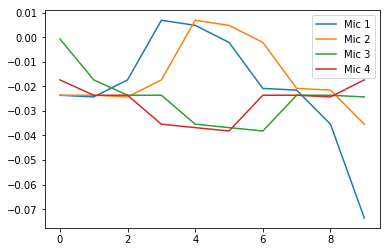

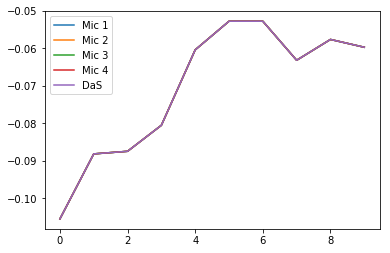

In [18]:
# SIMULANDO UM ARRAY DE MICS
objSimularArrayMics = SimularArrayMicrofones("/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono6Segundos.wav", energiaRuido=None, normalizarEnergia=True)
arraySinaisMics, delaysVerdadeiros, freqAmostragem = objSimularArrayMics.obterResultado()

# CORRIGINDO OS DELAYS
sinalDaS, arraySinaisAjustados = executarDaS(arraySinaisMics, delaysVerdadeiros, True)

# PLOTANDO ANTES E DEPOIS
inicio = 100000
fim    = inicio + 10

for i, sinalAtual in enumerate(arraySinaisMics):
    plt.plot(sinalAtual[inicio:fim], label="Mic "+str(i+1))
plt.legend()
plt.show()

for i, sinalAtual in enumerate(arraySinaisAjustados):
    plt.plot(sinalAtual[inicio:fim], label="Mic "+str(i+1))
plt.plot(sinalDaS[inicio:fim], label="DaS")
plt.legend()
plt.show()

## Passo a passo 

Vou começar simulando um array de microfones do zero pra só depois usar as funções criadas.

In [35]:
# COORDENADAS 
qtdMics = 100
coordenadasMics = []
for i in range(qtdMics):
    coordenadasMics.append([random()/10, random()/10, random()/10])
coordenadasMics = np.array(coordenadasMics)

# SEMPRE COLOCAR O MICROFNE DE REFERENCIA NA ORIGEM
for i, coordenadaAtual in enumerate(coordenadasMics):
    coordenadasMics[i] = coordenadaAtual - coordenadasMics[0]

# SIMULANDO O ARRAY DE MICROFONES ALEATORIAMENTE
energiaRuido = 0.05
objSimularArrayMics = SimularArrayMicrofones("/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono6Segundos.wav", energiaRuido, normalizarEnergia=True, coordenadasMics=coordenadasMics)
arraySinaisMics, delaysVerdadeiros, freqAmostragem = objSimularArrayMics.obterResultado()

# CALCULANDO O DELAY MAXIMO
delayMax = calcularDelayMaximo(coordenadasMics, freqAmostragem)

# CALCULANDO OS DELAYS
arrayDelays = calcularArrayDelays(arraySinaisMics, delayMax)

# APLICANDO O DaS
sinalDaS, arraySinaisAjustados = executarDaS(arraySinaisMics, arrayDelays)

# USANDO A CLASSE ANTIGA PRA COMPARAR
objBeamforming = GeneralizedSidelobeCanceller()
sinalBeamformadoAntigo, __ = objBeamforming.gerarSinalBeamformado(arraySinaisMics, objBeamforming.obterArrayDelays(arraySinaisMics))

print("Delays verdadeiros:", np.array(delaysVerdadeiros))
print("Delays calculados: ", arrayDelays)
print("Tamanho dos sinais originais:", len(arraySinaisMics[0]))
print("Tamanho dos sinal DaS:       ", len(sinalDaS))
print("Energia sem DaS:", np.var(np.sum(arraySinaisMics, axis=0)/len(arraySinaisMics)))
print("Energia com DaS:", np.var(sinalDaS))
print("Energia DaS ant:", np.var(sinalBeamformadoAntigo))

Delays verdadeiros: [ 0 12  4  5  6  0  3 11  3  2  7 12  9  4  3  3  7  5  4  3  7  3  5 13
  6  8  1  1 11 12  8  5 12 10  4  1 10  7  9  5 14  9  6  9  1 13  2 10
  4  1 10  4  3 12 11  4  1  0 10 11  7  6  3 11 10  2  7 10  5  2  5  3
  4 10 12 11 10 11  6  8  7 13  2 10  3  4 13  9  9 10 13  9  9  7  8  1
  4 11  7 13]
Delays calculados:  [ 0 12  4  5  6  0  3 11  3  2  7 12  9  4  3  3  7  5  4  3  7  3  5 13
  6  8  1  1 11 12  8  5 12 10  4  1 10  7  9  5 14  9  6  9  1 13  2 10
  4  1 10  4  3 12 11  4  1  0 10 11  7  6  3 11 10  2  7 10  5  2  5  3
  4 10 12 11 10 11  6  8  7 13  2 10  3  4 13  9  9 10 13  9  9  7  8  1
  4 11  7 13]
Tamanho dos sinais originais: 286584
Tamanho dos sinal DaS:        286542
Energia sem DaS: 0.909877313724132
Energia com DaS: 1.000704874453227
Energia DaS ant: 1.0005582795026828


In [36]:
print("SEM DaS")
Audio(data=np.sum(arraySinaisMics, axis=0)/len(arraySinaisMics), rate=freqAmostragem)

SEM DaS


In [37]:
print("COM DaS")
Audio(data=sinalDaS, rate=freqAmostragem)

COM DaS


In [38]:
print("COM DaS Antigo")
Audio(data=sinalBeamformadoAntigo, rate=freqAmostragem)

COM DaS Antigo


### Comparação de tempo de processamento

In [34]:
arrayTemposAntigo = []
arrayTemposNovo   = []

for i in range(0, 10):
    # SIMULANDO O ARRAY DE MICROFONES ALEATORIAMENTE, COM COORDENADAS PADRAO DO RESPEAKER
    coordenadasMics = np.array([[0,0,0],[0,0.04137,0.04137],[0.0585,0.04137,0.04137],[0.0585,0,0]])
    energiaRuido = 0.01
    objSimularArrayMics = SimularArrayMicrofones("/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono6Segundos.wav", energiaRuido, normalizarEnergia=True, coordenadasMics=coordenadasMics)
    arraySinaisMics, delaysVerdadeiros, freqAmostragem = objSimularArrayMics.obterResultado()

    # USANDO O ALGORITMO ATUAL
    inicioNovo = time.time()
    sinalDaS, arraySinaisAjustados = executarDaS(arraySinaisMics, calcularArrayDelays(arraySinaisMics, 20))
    fimNovo = time.time()

    # USANDO A CLASSE ANTIGA PRA COMPARAR
    objBeamforming = GeneralizedSidelobeCanceller()
    inicioAntigo = time.time()
    sinalBeamformadoAntigo, __ = objBeamforming.gerarSinalBeamformado(arraySinaisMics, objBeamforming.obterArrayDelays(arraySinaisMics))
    fimAntigo = time.time()

    arrayTemposAntigo.append(fimAntigo - inicioAntigo)
    arrayTemposNovo.append(fimNovo - inicioNovo)
    
tempoAntigo = np.mean(arrayTemposAntigo)
tempoNovo   = np.mean(arrayTemposNovo)

print("Antigo:", np.mean(arrayTemposAntigo), "+-", np.std(arrayTemposAntigo))
print("Novo:", np.mean(arrayTemposNovo), "+-", np.std(arrayTemposNovo))

Antigo: 0.5156847715377808 +- 0.0210531415635282
Novo: 0.15210843086242676 +- 0.034869252537913356
